In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import keras_tuner as kt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [1]:
!pip install keras-tuner

In [3]:
from google.colab import files
import pandas as pd

# Upload CSV
uploaded = files.upload()

Saving Polygon_cleaned.csv to Polygon_cleaned (1).csv


In [4]:
# Read the CSV (assuming only one file is uploaded)
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

In [6]:
"""# Convert 'Timestamp' to datetime object
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Drop any rows where conversion failed (NaT values)
df = df.dropna(subset=['Timestamp'])

# Add a new column with just the date (YYYY-MM-DD)
df['Date'] = df['Timestamp'].dt.date



# Check the changes
df[['Timestamp']].head()"""


"# Convert 'Timestamp' to datetime object\ndf['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')\n\n# Drop any rows where conversion failed (NaT values)\ndf = df.dropna(subset=['Timestamp'])\n\n# Add a new column with just the date (YYYY-MM-DD)\ndf['Date'] = df['Timestamp'].dt.date\n\n\n\n# Check the changes\ndf[['Timestamp']].head()"

In [5]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True, errors='coerce')



In [6]:
df.shape

(707, 25)

In [7]:
df.head()


,Timestamp,Open,High,Low,Close,VWAP,Volume,Count,Crypto,Volatility,...,Close_Lag_2,Close_Lag_3,Rolling_Std_7,Rolling_Std_14,EMA_7,EMA_14,MACD,Day_of_Week,Month,Week_of_Year
0,2023-03-08,1.1502,1.1576,1.0402,1.0511,1.0907,14300000.0,10405,Polygon,0.1174,...,1.1318,1.1349,0.052642,0.078942,1.138538,1.188944,-0.050406,2,3,10
1,2023-03-09,1.0512,1.0935,0.9736,1.0165,1.0392,13100000.0,11501,Polygon,0.1199,...,1.1498,1.1318,0.055794,0.080011,1.108029,1.165952,-0.057923,3,3,10
2,2023-03-10,1.0171,1.0693,0.9431,1.0618,1.0066,22400000.0,13489,Polygon,0.1262,...,1.0511,1.1498,0.051991,0.081292,1.096471,1.152065,-0.055593,4,3,10
3,2023-03-11,1.0613,1.0961,0.9924,1.0633,1.0392,11400000.0,10000,Polygon,0.1037,...,1.0165,1.0511,0.051155,0.081333,1.088179,1.140229,-0.052051,5,3,10
4,2023-03-12,1.0645,1.1609,1.0476,1.1556,1.1042,11600000.0,11355,Polygon,0.1133,...,1.0618,1.0165,0.054849,0.072248,1.105034,1.142279,-0.037245,6,3,10


In [8]:
crypto = "Polygon"

In [9]:
# Selecting relevant columns for LSTM
features = ['Open', 'High', 'Low', 'Volume', 'VWAP', 'Volatility', 'Price_Change', 'RSI', 'MACD',
            'MA_7', 'MA_14', 'EMA_7', 'EMA_14', 'Rolling_Std_7', 'Rolling_Std_14',
            'Day_of_Week', 'Month', 'Week_of_Year', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']
target = 'Close'

In [10]:
crypto_df = df[df['Crypto'] == crypto].drop(columns=['Crypto']).dropna()

In [11]:
df.isnull().sum()

,0
Timestamp,427
Open,0
High,0
Low,0
Close,0
VWAP,0
Volume,0
Count,0
Crypto,0
Volatility,0


In [12]:
df[['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']] = df[['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']].fillna(method='ffill')
df[['Rolling_Std_7', 'Rolling_Std_14']] = df[['Rolling_Std_7', 'Rolling_Std_14']].interpolate(method='linear')

print(df.isnull().sum())

Timestamp         427
Open                0
High                0
Low                 0
Close               0
VWAP                0
Volume              0
Count               0
Crypto              0
Volatility          0
Price_Change        0
RSI                 0
MA_7                0
MA_14               0
Close_Lag_1         0
Close_Lag_2         0
Close_Lag_3         0
Rolling_Std_7       0
Rolling_Std_14      0
EMA_7               0
EMA_14              0
MACD                0
Day_of_Week         0
Month               0
Week_of_Year        0
dtype: int64


<ipython-input-12-5ec87b0f3c38>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']] = df[['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']].fillna(method='ffill')


In [13]:
# 🚀 Drop Remaining Rows with Missing Values
df.dropna(inplace=True)

# ✅ Verify all missing values are gone
print(df.isnull().sum())  # Should print all zeros

# ✅ Check dataset size after dropping rows
print(f"Dataset size after dropping missing values: {df.shape}")


Timestamp         0
Open              0
High              0
Low               0
Close             0
VWAP              0
Volume            0
Count             0
Crypto            0
Volatility        0
Price_Change      0
RSI               0
MA_7              0
MA_14             0
Close_Lag_1       0
Close_Lag_2       0
Close_Lag_3       0
Rolling_Std_7     0
Rolling_Std_14    0
EMA_7             0
EMA_14            0
MACD              0
Day_of_Week       0
Month             0
Week_of_Year      0
dtype: int64
Dataset size after dropping missing values: (280, 25)


In [14]:
df.head()

,Timestamp,Open,High,Low,Close,VWAP,Volume,Count,Crypto,Volatility,...,Close_Lag_2,Close_Lag_3,Rolling_Std_7,Rolling_Std_14,EMA_7,EMA_14,MACD,Day_of_Week,Month,Week_of_Year
0,2023-03-08,1.1502,1.1576,1.0402,1.0511,1.0907,14300000.0,10405,Polygon,0.1174,...,1.1318,1.1349,0.052642,0.078942,1.138538,1.188944,-0.050406,2,3,10
1,2023-03-09,1.0512,1.0935,0.9736,1.0165,1.0392,13100000.0,11501,Polygon,0.1199,...,1.1498,1.1318,0.055794,0.080011,1.108029,1.165952,-0.057923,3,3,10
2,2023-03-10,1.0171,1.0693,0.9431,1.0618,1.0066,22400000.0,13489,Polygon,0.1262,...,1.0511,1.1498,0.051991,0.081292,1.096471,1.152065,-0.055593,4,3,10
3,2023-03-11,1.0613,1.0961,0.9924,1.0633,1.0392,11400000.0,10000,Polygon,0.1037,...,1.0165,1.0511,0.051155,0.081333,1.088179,1.140229,-0.052051,5,3,10
4,2023-03-12,1.0645,1.1609,1.0476,1.1556,1.1042,11600000.0,11355,Polygon,0.1133,...,1.0618,1.0165,0.054849,0.072248,1.105034,1.142279,-0.037245,6,3,10


In [15]:
df = df.drop_duplicates(subset=['Timestamp'], keep='first')

# Sort data by Timestamp
df = df.sort_values(by=['Timestamp'])

In [19]:
df.to_csv('Polygon_cleaned_modified.csv', index=False)

# Download the file to your local system
from google.colab import files
files.download('Polygon_cleaned_modified.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Save cleaned dataset
cleaned_csv_path = "C:\\Users\\annae\\Downloads\\Polygon_cleaned_modified.csv"

df.to_csv(cleaned_csv_path, index=False)

# Confirm file saved
print(f"Cleaned dataset saved at: {cleaned_csv_path}")

Cleaned dataset saved at: C:\Users\annae\Downloads\Polygon_cleaned_modified.csv


In [17]:
df = pd.read_csv("C:\\Users\\annae\\Downloads\\Polygon_cleaned_modified.csv")

In [18]:
import plotly.express as px

fig = px.line(df, x=df['Timestamp'], y=df['Close'], labels={'Timestamp': 'Date', 'Close': 'Close Price'})


# Update trace settings
fig.update_traces(
    marker_line_width=2,
    opacity=0.8,
    marker_line_color='orange'
)

# Update layout with title and styling
fig.update_layout(
    title_text='Whole period of timeframe of Polygon close price ',
    plot_bgcolor='white',
    font_size=15,
    font_color='black'
)

# Remove grid from x and y axes
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Show plot
fig.show()


<ipython-input-20-1448172f25c7>:15: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

<ipython-input-20-1448172f25c7>:22: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 882ms/step - loss: 0.0806
Epoch 2/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 881ms/step - loss: 0.0138
Epoch 3/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 880ms/step - loss: 0.0076
Epoch 4/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 887ms/step - loss: 0.0067
Epoch 5/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 885ms/step - loss: 0.0062
Epoch 6/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 890ms/step - loss: 0.0054
Epoch 7/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 907ms/step - loss: 0.0058
Epoch 8/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 894ms/step - loss: 0.0043
Epoch 9/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0043
Epoch 10/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 892ms/step - loss: 0.0048
Epoch 11/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 891ms/step - loss: 0.0041
Epoch 12/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 887ms/step - loss: 0.0034
Epoch 13/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 886ms/step - loss: 0.0039
Epoch 14/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 892ms/step - loss: 0.0037
Epoch 15/150
15/15 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.



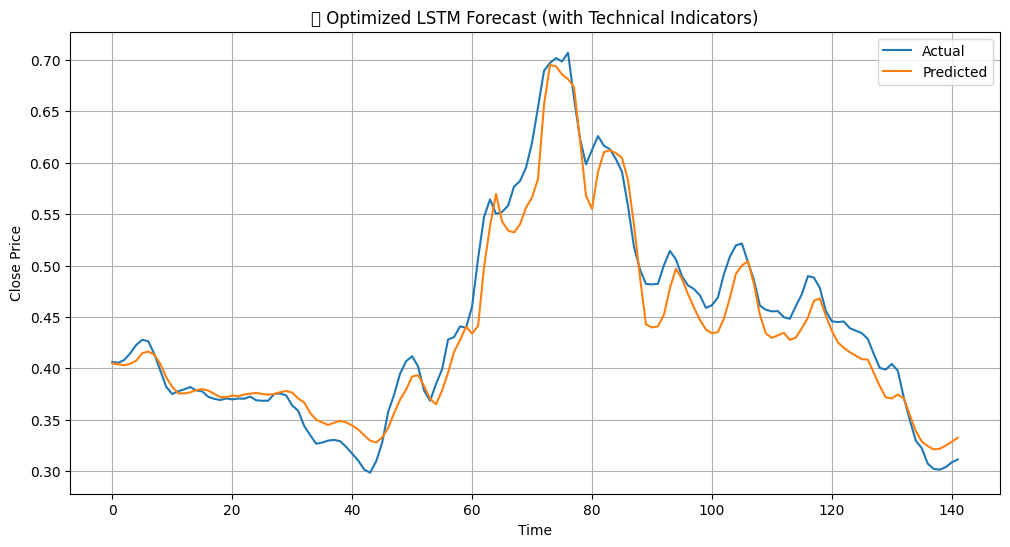

✅ Model saved successfully at: C:\Users\annae\Downloads\polygon_lstm_bidirectional_model.h5


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model

# Load dataset
df = pd.read_csv('/content/Polygon_cleaned.csv')

# Optional: Smooth Close prices to reduce noise
df['Close'] = df['Close'].rolling(window=3).mean().fillna(method='bfill')

# Add technical indicators
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['RSI'] = 100 - (100 / (1 + df['Close'].pct_change().rolling(14).mean().fillna(0)))

# Fill missing values (from indicators)
df.fillna(method='bfill', inplace=True)

# Features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_10', 'RSI']
data = df[features].values

# Parameters
seq_length = 100
train_ratio = 0.8
split_idx = int(train_ratio * len(data))

# Normalize only on training data
scaler = MinMaxScaler()
scaler.fit(data[:split_idx])
data_scaled = scaler.transform(data)

# Create sequences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len][3])  # Close index
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(data_scaled, seq_length)

# Split into train/test
X_train, X_test = X_all[:split_idx - seq_length], X_all[split_idx - seq_length:]
y_train, y_test = y_all[:split_idx - seq_length], y_all[split_idx - seq_length:]

# Model
model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(seq_length, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train
history = model.fit(X_train, y_train, epochs=150, batch_size=32, callbacks=[early_stop], verbose=1)

# Predict and inverse scale
y_pred_scaled = model.predict(X_test)

# Inverse transform using close scaler
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]
y_test_actual = close_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = close_scaler.inverse_transform(y_pred_scaled)

# R² Score
r2 = r2_score(y_test_actual, y_pred_actual)
print(f"🔍 R² Score: {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.title('🔮 Optimized LSTM Forecast (with Technical Indicators)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# ✅ Save the trained LSTM model
model_save_path = "C:\\Users\\annae\\Downloads\\polygon_lstm_bidirectional_model.h5"
model.save(model_save_path)
print(f"✅ Model saved successfully at: {model_save_path}")


In [21]:
import pandas as pd

# Load the polygon dataset
polygon_data_path = "C:\\Users\\annae\\Downloads\\Polygon_cleaned_modified.csv"
polygon_df = pd.read_csv(polygon_data_path)

# Convert Timestamp to datetime (auto-detects ISO format)
polygon_df['Timestamp'] = pd.to_datetime(polygon_df['Timestamp'], format='ISO8601')

# Set timestamp as index
polygon_df.set_index('Timestamp', inplace=True)

# Define target variable (Close price)
close_prices = polygon_df['Close']

# Define exogenous features
features = ['MACD', 'EMA_7', 'Close_Lag_1']
exog_features = polygon_df[features]

# Display first few rows
print(polygon_df.head())



              Open    High     Low   Close    VWAP      Volume  Count  \
Timestamp                                                               
2023-03-08  1.1502  1.1576  1.0402  1.0511  1.0907  14300000.0  10405   
2023-03-09  1.0512  1.0935  0.9736  1.0165  1.0392  13100000.0  11501   
2023-03-10  1.0171  1.0693  0.9431  1.0618  1.0066  22400000.0  13489   
2023-03-11  1.0613  1.0961  0.9924  1.0633  1.0392  11400000.0  10000   
2023-03-12  1.0645  1.1609  1.0476  1.1556  1.1042  11600000.0  11355   

             Crypto  Volatility  Price_Change  ...  Close_Lag_2  Close_Lag_3  \
Timestamp                                      ...                             
2023-03-08  Polygon      0.1174       -0.0987  ...       1.1318       1.1349   
2023-03-09  Polygon      0.1199       -0.0346  ...       1.1498       1.1318   
2023-03-10  Polygon      0.1262        0.0453  ...       1.0511       1.1498   
2023-03-11  Polygon      0.1037        0.0015  ...       1.0165       1.0511   
2023-03-

In [22]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test on Close Price
adf_test = adfuller(close_prices)

print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

if adf_test[1] < 0.05:
    print("✅ Data is stationary, ARIMA can be applied directly (d=0).")
else:
    print("⚠️ Data is non-stationary, differencing is required (d>0).")


ADF Statistic: -1.542203487795171
p-value: 0.5125402585753535
⚠️ Data is non-stationary, differencing is required (d>0).


In [23]:
# Apply first-order differencing if needed
diff_close_prices = close_prices.diff().dropna()

# Perform ADF test again
adf_test_diff = adfuller(diff_close_prices)

print(f"After Differencing - ADF Statistic: {adf_test_diff[0]}")
print(f"After Differencing - p-value: {adf_test_diff[1]}")

if adf_test_diff[1] < 0.05:
    print("✅ Data is now stationary, ARIMA can be applied with d=1.")
else:
    print("⚠️ Still non-stationary, consider d=2.")

After Differencing - ADF Statistic: -16.031503272803796
After Differencing - p-value: 6.050120350125332e-29
✅ Data is now stationary, ARIMA can be applied with d=1.


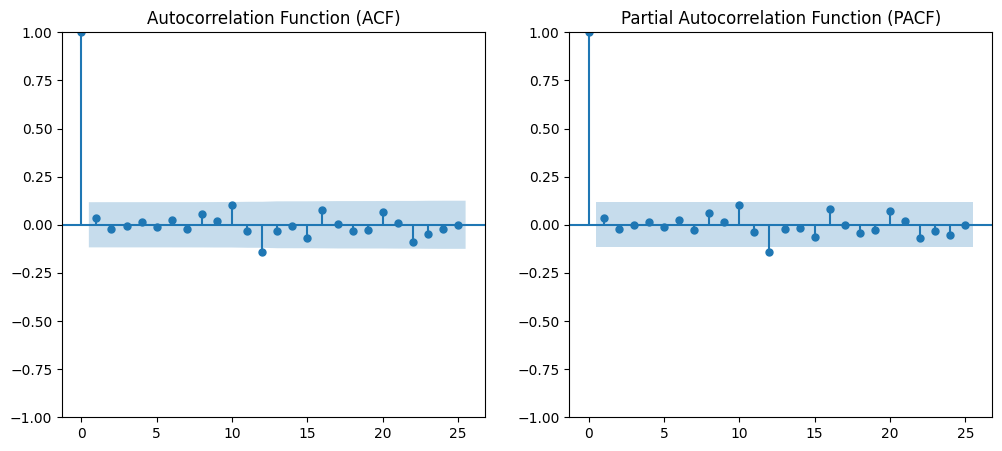

In [24]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF Plot (for q)
plot_acf(diff_close_prices, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF Plot (for p)
plot_pacf(diff_close_prices, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()


In [25]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Define possible values for p, d, q, P, D, Q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
s = [7]  # Weekly seasonality

best_mae = float("inf")
best_params = None
best_model = None

# Grid search over all combinations
for param in itertools.product(p, d, q, P, D, Q, s):
    try:
        model = SARIMAX(close_prices, exog=exog_features, order=param[:3], seasonal_order=param[3:])
        result = model.fit(disp=False)

        # Forecast for last 30 days
        forecast = result.forecast(steps=30, exog=exog_features.iloc[-30:])

        # Compute MAE
        mae = mean_absolute_error(close_prices[-30:], forecast)

        if mae < best_mae:
            best_mae = mae
            best_params = param
            best_model = result

    except:
        continue

print(f"✅ Best SARIMAX Parameters: {best_params} with MAE: {best_mae}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been pro

✅ Best SARIMAX Parameters: (0, 0, 0, 1, 1, 0, 7) with MAE: 0.019998283344686296


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train the final optimized SARIMAX model
sarimax_final = SARIMAX(close_prices, exog=exog_features,
                        order=(0, 0, 0), seasonal_order=(0, 0, 1, 7))
sarimax_result_final = sarimax_final.fit()

# Print summary of the final model
print(sarimax_result_final.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 SARIMAX Results                                 
Dep. Variable:                     Close   No. Observations:                  280
Model:             SARIMAX(0, 0, [1], 7)   Log Likelihood                 655.929
Date:                   Sat, 05 Apr 2025   AIC                          -1301.858
Time:                           18:23:09   BIC                          -1283.684
Sample:                                0   HQIC                         -1294.568
                                   - 280                                         
Covariance Type:                     opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
MACD            1.2069      0.068     17.832      0.000       1.074       1.340
EMA_7           1.0772      0.055     19.546      0.000       0.969       1.185
Close_Lag_1    -0.0769  

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Forecast next 30 days
sarimax_forecast = sarimax_result_final.forecast(steps=30, exog=exog_features.iloc[-30:])

# Compute Performance Metrics
mae_sarimax = mean_absolute_error(close_prices[-30:], sarimax_forecast)
mse_sarimax = mean_squared_error(close_prices[-30:], sarimax_forecast)
rmse_sarimax = np.sqrt(mse_sarimax)
r2_sarimax = r2_score(close_prices[-30:], sarimax_forecast)

sarimax_performance = {
    "MAE": mae_sarimax,
    "MSE": mse_sarimax,
    "RMSE": rmse_sarimax,
    "R-squared": r2_sarimax
}

print("📊 Final SARIMAX Performance Metrics:", sarimax_performance)


📊 Final SARIMAX Performance Metrics: {'MAE': 0.02260058761826255, 'MSE': 0.0009393420249959509, 'RMSE': np.float64(0.03064868716594482), 'R-squared': 0.9444955684910104}


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



<ipython-input-32-a6dac145417a>:17: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


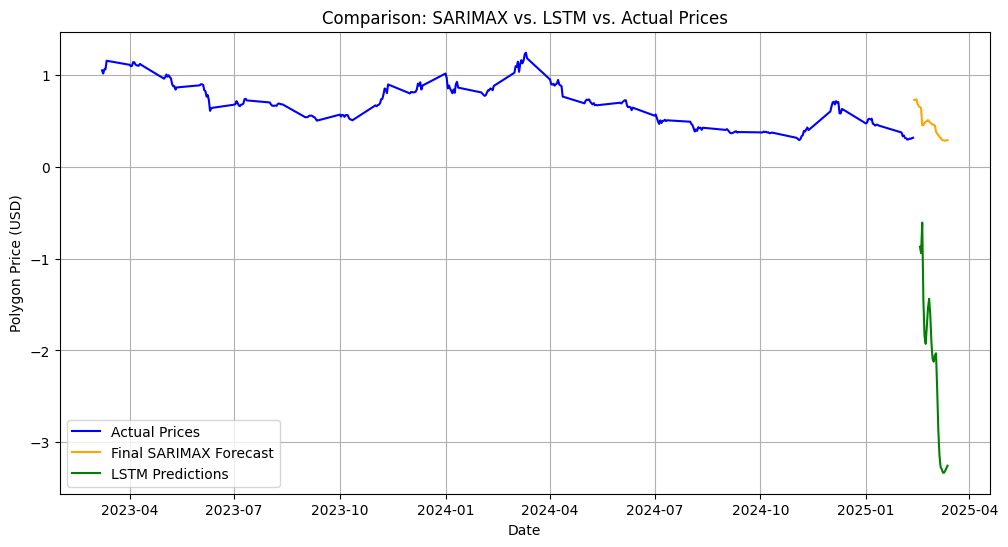

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model

# Load trained LSTM model
lstm_model_path = r"C:\Users\annae\Downloads\polygon_lstm_bidirectional_model.h5"
lstm_model = load_model(lstm_model_path, compile=False)
lstm_model.compile(optimizer='adam', loss=MeanSquaredError())

# Ensure polygon_df and close_prices are already defined before this block
# Recreate technical indicators
polygon_df['EMA_10'] = polygon_df['Close'].ewm(span=10, adjust=False).mean()
polygon_df['RSI'] = 100 - (100 / (1 + polygon_df['Close'].pct_change().rolling(14).mean().fillna(0)))
polygon_df.fillna(method='bfill', inplace=True)

# Normalize data before feeding into LSTM
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_10', 'RSI']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(polygon_df[features])

# Prepare test data for LSTM
look_back = 5
test_scaled = scaled_data[-30:]  # Last 30 days for testing
X_test = []
for i in range(look_back, len(test_scaled)):
    X_test.append(test_scaled[i - look_back:i, :])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], look_back, len(features)))

# LSTM Predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform predictions (rebuild input shape with dummy values except for Close)
lstm_predictions = scaler.inverse_transform(
    np.concatenate([np.zeros((lstm_predictions.shape[0], len(features) - 1)), lstm_predictions], axis=1)
)[:, -1]  # Extract only Close Price

# Generate future dates for plotting (30 days ahead)
final_future_dates = pd.date_range(start=close_prices.index[-1], periods=30 + 1, freq='D')[1:]

# Adjust test index for LSTM predictions (aligned with available test data)
lstm_test_index = final_future_dates[look_back:]

# Plot SARIMAX vs. LSTM vs. Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(close_prices.index, close_prices, label="Actual Prices", color='blue')
plt.plot(final_future_dates, sarimax_forecast, label="Final SARIMAX Forecast", color='orange')
plt.plot(lstm_test_index, lstm_predictions, label="LSTM Predictions", color='green')

plt.xlabel('Date')
plt.ylabel('Polygon Price (USD)')
plt.title("Comparison: SARIMAX vs. LSTM vs. Actual Prices")
plt.legend()
plt.grid()
plt.show()
